In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from datetime import datetime
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from bikes.evaluate.config import TEST_LOCATIONS
from bikes.evaluate.split import train_test_split
from bikes.evaluate.metrics import mape, mase

In [140]:
def file_from_location(location: str, suffix: str) -> str:
    location = location.replace(" -", "").replace(" ", "_").lower()
    return location + suffix

## Compare Forecasts

In [44]:
FORECAST_BASE_PATH = Path("./forecasts/")
MODELS = ["ets", "sarimax", "theta", "prophet", "rnn", "lstm", "deepar"]

In [45]:
cycle_counts = pd.read_csv("cycle_counts.csv", parse_dates=["date"])

In [141]:
# Load forecasts

all_forecasts = {}

for location in TEST_LOCATIONS:
    all_forecasts[location] = {}
    
    location_df = cycle_counts.loc[cycle_counts["location"] == location].copy()
    location_df = location_df.set_index("date").sort_index()

    train_df, test_df = train_test_split(location_df)
    all_forecasts[location]["train_df"] = train_df
    all_forecasts[location]["test_df"] = test_df

    location_csv = file_from_location(location, ".csv")
    forecast_df = test_df.copy()
    for model in MODELS:
        model_forecasts = pd.read_csv(
            FORECAST_BASE_PATH / model / location_csv,
            index_col=0,
            parse_dates=["date"],
            dtype={"ytrue": int, f"yhat_{model}": float}
        )

        assert (model_forecasts["location"] == location).all()
        assert (model_forecasts["date"].isin(test_df.index)).all()
        model_forecasts = model_forecasts.drop(columns=["location"]).set_index("date")

        forecast_df = pd.merge(
            left=forecast_df,
            right=model_forecasts,
            left_index=True,
            right_index=True,
            how="left"
        )
        
        assert (forecast_df["count"] == forecast_df["ytrue"]).all()
        forecast_df = forecast_df.drop(columns=["ytrue"])

    forecast_df = forecast_df.rename(columns={"count": "ytrue"})
    all_forecasts[location]["forecast_df"] = forecast_df

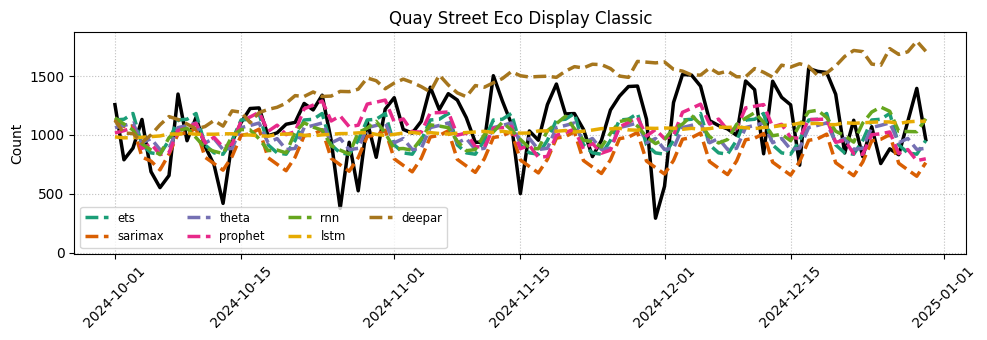

In [170]:
# Plot forecasts

location = TEST_LOCATIONS[18]
forecast_df = all_forecasts[location]["forecast_df"]

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))
colors = sns.color_palette("Dark2", n_colors=len(MODELS))

# Ground truth
ax.plot(
    forecast_df.index,
    forecast_df["ytrue"].values,
    color="black",
    lw=2.5,
)

# Model forecasts
for i, model in enumerate(MODELS):
    color = colors[i % len(colors)]
    ax.plot(
        forecast_df.index,
        forecast_df[f"yhat_{model}"].values,
        color=color,
        lw=2.5,
        label=model,
        ls="--",
    )

ax.set(ylabel="Count", title=location, ylim=(-10, None))
ax.legend(frameon=True, loc="lower left", ncol=4, fontsize="small")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, linestyle=":", alpha=0.8)
fig.tight_layout()
plt.savefig(f"./plots/{file_from_location(location, '.png')}", dpi=300);

In [ ]:
# Compute metrics

